# **Lab-11-4 RNN timeseries**

## **Time series data**

![](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fk.kakaocdn.net%2Fdn%2FcvUSQ8%2FbtqzMVjklFI%2FLuYBcAKMdIcar1UxSdDnk0%2Fimg.png)

시계열 데이터, 즉 일정한 시간 간격으로 배치된 data를 뜻한다. 주가 data가 대표적인 시계열 data이다.  

## **Apply RNN : Many-to-One**

따라서 일 별 구글 주가 data를 RNN에 적용시켜 볼 것인데, 이 데이터는 구글 주식의 시작가, 그날의 최고가, 최저가, 거래량, 종가를 일별로 정리해 둔 데이터이다.

![](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fk.kakaocdn.net%2Fdn%2FB87yb%2FbtqzKGgBLmp%2FsRo9itrSBxcABvibecbWdK%2Fimg.png)

Many to one 구조를 사용할 것이다.
일주일 간의 데이터를 넣고 그 다음날의 주가를 예측하는 구조이다.

위의 표에서 각각의 row가 차례대로 셀에 입력된다. 

vector가 5개의 dimension을 가지고 있으므로   Input 길이는 5, sequence 길이는 7, Output 길이는 1임을 알 수 있다.

만약 model이 8일차 종가를 바로 예측한다고 한다면, output은 dimension 1짜리 vector가 될 것이다. 

모델에 가해지는 부담을 줄이기 위해 다음 셀에 넘겨지는 hidden state를 충분히 보장해 주고 마지막에 출력된 vector에 FC layer를 연결해서 그 output이 종가를 맞추도록 구성한다.

데이터를 유통하는 부분과 유통된 데이터로 label을 맞추는 부분을 분리하는 것이다. 이렇게 특정 web 접속에 가해지는 부담을 분산시키는 것은 network 구성에 있어 중요한 테크닉 중 하나이다.



## **Apply RNN : Data Reading**

In [28]:
import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [29]:
# Random seed to make results deterministic and reproducible
torch.manual_seed(0)

In [30]:
# scaling function for input data
def minmax_scaler(data):
  numerator = data - np.min(data, 0) 
  denominator = np.max(data, 0) - np.min(data, 0)
  return numerator / (denominator + 1e-7)

![](https://taewanmerepo.github.io/2017/09/numpy_axis/axis0.png)
np.min(data, 0)과 np.max(data, 0)에서 0은 axis=0을 의미하고, 이는 각 dimension안에서의 최소, 최댓값을 구하도록 한다.

In [31]:
# make dataset to input
def build_dataset(time_series, seq_length):
  dataX = []
  dataY = []
  for i in range(0, len(time_series) - seq_length):
    _x = time_series[i:i + seq_length, :]
    _y = time_series[i + seq_length, [-1]] # Next close price
    print(_x, "->", _y)
    dataX.append(_x)
    dataY.append(_y)
  return np.array(dataX), np.array(dataY)

In [32]:
# hyper parameters
seq_length = 7 # 7일
data_dim = 5 # 시작가, 최고가, 최저가, 거래량, 종가
hidden_dim = 10
output_dim = 1 # FC가 맞춰야하는 종가의 dimension
learning_rate = 0.01
iterations = 500


In [33]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [34]:
# load data
xy = np.loadtxt("/content/gdrive/My Drive/Colab Notebooks/data-02-stock_daily.csv", delimiter=",")
xy = xy[::-1] # reverse order

# split train-test set
train_size = int(len(xy) * 0.7)
train_set = xy[0:train_size]
test_set = xy[train_size - seq_length:]

# 각 dim의 값은 [0,1]의 값으로 스케일링
# 모델이 scale값까지 학습해야되는 부담을 덜도록
train_set = minmax_scaler(train_set)
test_set = minmax_scaler(test_set)

# 7일간의 입력과, 8일차의 종가로 나눠서 dataset구성
trainX, trainY = build_dataset(train_set, seq_length)
testX, testY = build_dataset(test_set, seq_length)

# tesnsor형태로 변환
trainX_tensor = torch.FloatTensor(trainX)
trainY_tensor = torch.FloatTensor(trainY)

testX_tensor = torch.FloatTensor(testX)
testY_tensor = torch.FloatTensor(testY)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
 [0.14300667 0.13856872 0.13617972 0.22934481 0.12698631]] -> [0.14877846]
[[0.13075879 0.14979736 0.13950917 0.35107108 0.1339569 ]
 [0.15042457 0.16374824 0.15035617 0.23008873 0.14071632]
 [0.14549092 0.14452321 0.11061926 0.34481491 0.154517  ]
 [0.16681257 0.20764196 0.18773052 0.4378686  0.22527992]
 [0.18685758 0.18212236 0.1560484  0.60962624 0.15331987]
 [0.14300667 0.13856872 0.13617972 0.22934481 0.12698631]
 [0.1172689  0.14037216 0.1430174  0.21129336 0.14877846]] -> [0.12107173]
[[0.15042457 0.16374824 0.15035617 0.23008873 0.14071632]
 [0.14549092 0.14452321 0.11061926 0.34481491 0.154517  ]
 [0.16681257 0.20764196 0.18773052 0.4378686  0.22527992]
 [0.18685758 0.18212236 0.1560484  0.60962624 0.15331987]
 [0.14300667 0.13856872 0.13617972 0.22934481 0.12698631]
 [0.1172689  0.14037216 0.1430174  0.21129336 0.14877846]
 [0.13503702 0.12893923 0.13850679 0.18323922 0.12107173]] -> [0.11480508]
[[0.14549092 0.14452321 0.11061926 0.344814

## **Apply RNN : Neural Net Setting**

In [42]:
class Net(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, layers):
        super(Net, self).__init__()
        self.rnn = torch.nn.LSTM(input_dim, hidden_dim, num_layers=layers, batch_first=True)
        self.fc = torch.nn.Linear(hidden_dim, output_dim, bias=True)

    def forward(self, x):
        x, _status = self.rnn(x)
        x = self.fc(x[:, -1])
        return x


net = Net(data_dim, hidden_dim, output_dim, 1)

In [43]:
# loss & optimizer setting
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

## **Apply RNN : Training & Evaluation**

In [44]:
# start training
for i in range(iterations):

    optimizer.zero_grad()
    outputs = net(trainX_tensor)
    loss = criterion(outputs, trainY_tensor)
    loss.backward()
    optimizer.step()
    print(i, loss.item())

0 0.38587281107902527
1 0.32303759455680847
2 0.26773858070373535
3 0.21690307557582855
4 0.1696799099445343
5 0.12657985091209412
6 0.08947890996932983
7 0.061235323548316956
8 0.04523169994354248
9 0.04427093639969826
10 0.05593610927462578
11 0.06871341913938522
12 0.07331983745098114
13 0.06908949464559555
14 0.05963829159736633
15 0.04895835742354393
16 0.039763499051332474
17 0.03321840614080429
18 0.029326017946004868
19 0.027472175657749176
20 0.026851527392864227
21 0.026711568236351013
22 0.026459094136953354
23 0.02568979747593403
24 0.024184390902519226
25 0.021895326673984528
26 0.018933305516839027
27 0.015551360324025154
28 0.012115015648305416
29 0.009043710306286812
30 0.0067159696482121944
31 0.005354214925318956
32 0.004931488540023565
33 0.005154756363481283
34 0.005560786928981543
35 0.005704517010599375
36 0.005348488688468933
37 0.004542700480669737
38 0.0035567875020205975
39 0.002723218174651265
40 0.0022845976054668427
41 0.0023086871951818466
42 0.00268760719

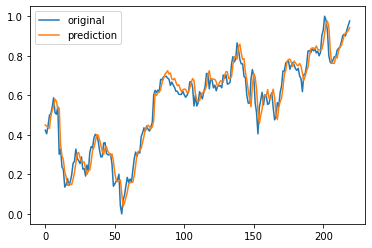

In [45]:
plt.plot(testY)
plt.plot(net(testX_tensor).data.numpy())
plt.legend(['original', 'prediction'])
plt.show()